In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import sqlalchemy as sa
import os


In [75]:
engine = sa.create_engine(os.environ["EW_CONNECT"])
sql = """
select 
    player
    ,player_upper
    ,api_id::integer
    ,birthday
    ,season_age
    ,position
    ,position_type
    ,shoots
    ,team
    ,season
    ,session
    ,gp
    ,toi
    ,toi_gp
    ,toi_perc
    ,g
    ,a1
    ,a2
    ,points
from skater_std_sum_all
where session = 'R'
"""

In [164]:
nhl_df = pd.read_sql(sql, engine)
#convert season to integers
nhl_df.season = nhl_df.season.astype(int)
#create a column to join on to get the next season
nhl_df['season_minus_one'] = nhl_df['season'] - 10001
nhl_df = nhl_df.groupby(['player', 'api_id', 'season', 'season_minus_one', 'position_type'])['g'].sum().reset_index()

In [165]:
#create dataframe of season to season goal correlation
new_df = nhl_df[['player', 'api_id', 'g', 'season', 'season_minus_one', 'position_type']].merge(
        nhl_df[['player', 'api_id', 'g', 'season', 'season_minus_one', 'position_type']], how='inner',
        left_on=['api_id', 'season'], right_on=['api_id', 'season_minus_one'])

#create dataframe for forwards only
forwards_df = new_df[new_df.position_type_x == 'F']
#create dataframe for defense only
defense_df = new_df[new_df.position_type_x == 'D']

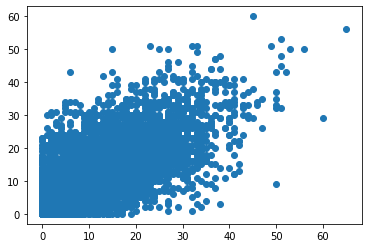

In [166]:
#total scatter correlation
plt.scatter(new_df[['g_x']], new_df[['g_y']])

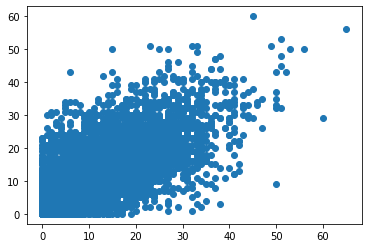

In [167]:
#forwards scatter
plt.scatter(forwards_df[['g_x']], forwards_df[['g_y']])

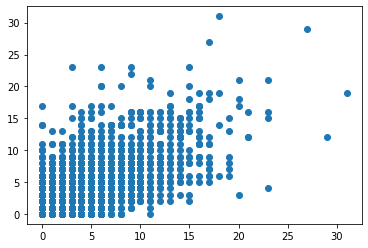

In [168]:
#defense scatter
plt.scatter(defense_df[['g_x']], defense_df[['g_y']])

In [169]:
forward_corr = forwards_df['g_x'].corr(forwards_df['g_y'])
def_corr = defense_df['g_x'].corr(defense_df['g_y'])
total_corr = new_df['g_x'].corr(new_df['g_y'])

In [170]:
print(f"Foward pearson R: {round(forward_corr, 2)}\n",
      f"Defense pearson R: {round(def_corr, 2)}\n",
      f"All Position Pearson R: {round(total_corr, 2)}")

Foward pearson R: 0.71
 Defense pearson R: 0.65
 All Position Pearson R: 0.75


(array([4.695e+03, 1.624e+03, 1.178e+03, 6.000e+02, 3.720e+02, 1.210e+02,
        5.700e+01, 1.500e+01, 3.000e+00, 2.000e+00]),
 array([ 0. ,  6.5, 13. , 19.5, 26. , 32.5, 39. , 45.5, 52. , 58.5, 65. ]),
 <BarContainer object of 10 artists>)

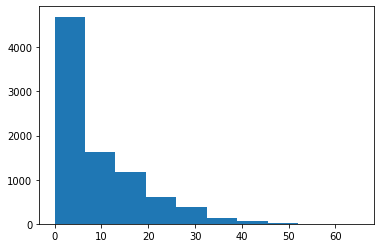

In [171]:
plt.hist(new_df.g_x)

(array([4.333e+03, 1.834e+03, 1.107e+03, 6.900e+02, 4.000e+02, 1.950e+02,
        7.200e+01, 2.100e+01, 1.300e+01, 2.000e+00]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <BarContainer object of 10 artists>)

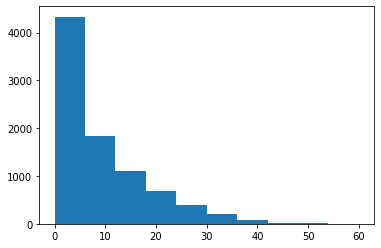

In [172]:
plt.hist(new_df.g_y)

In [190]:
season_2011 = new_df[(new_df.season_x == 20112012)]
season_2011 = season_2011.sort_values('g_x', ascending=False)
season_2011['cum_g'] = season_2011.g_x.cumsum()

In [202]:
season_2011.g_x.sum() * .7

4334.4

In [192]:
season_2011.shape

(708, 12)

In [203]:
season_2011[season_2011.cum_g <= 4334.4].shape

(201, 12)

In [204]:
201/708

0.2838983050847458

In [208]:
new_df = new_df.sort_values('g_x', ascending=False)
new_df['cum_g'] = new_df.g_x.cumsum()

In [209]:
new_df['g_x'].sum()*.7

52684.799999999996

In [210]:
thirty = new_df[new_df.cum_g <= 52684]

In [211]:
len(thirty.api_id.unique())

683

In [218]:
len(new_df.api_id.unique())

1888

In [219]:
683/1888

0.3617584745762712

In [ ]:
#write a funciton to determine the pareto division of how much of the fat tail is held by what 
#percentage of players

In [216]:
#pareto distribution function
import math
alpha = 1/(1-(math.log10(.7)/math.log10(0.3)))
x_sub_m = 1
def pareto_prob(x):
    """
    returns probability that some number X will be greater than x by the distribution of the Pareto curve
    defined by observed goal scoring behavior
    """
    alpha = 1/(1-(math.log10(.7)/math.log10(0.3)))
    x_sub_m = 1
    return (x_sub_m/x)^alpha